In [1]:
import cmdstanpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from cmdstanpy import CmdStanModel, cmdstan_path
from IPython.display import Image
import seaborn as sns

# Predator-Prey Population Dynamics: the Lotka-Volterra model in Stan

translated by Hyunji Moon, Jungin Choi


<a href = '#Data:-Lynx-and-Hare-Pelts-in-Canada'>Data: Lynx and Hare Pelts in Canada</a>

<a href = '#Mechanistic-Model:-The-Lotka-Volterra-Equations'>Mechanistic Model: The Lotka-Volterra Equations</a>

<a href = '#Statistical-Model:-Prior-Knowledge-and-Unexplained-Variation'>Statistical Model: Prior Knowledge and Unexplained Variation</a>

<a href = '#Coding-the-Model:-Stan-Program'>Coding the Model: Stan Program</a>

<a href = '#Solving-the-Inverse-Problem'>Solving the Inverse Problem: Bayesian Inference in Stan</a>

<a href = '#Conclusion:-What-are-the-Population-Dynamics?'>Conclusion: What are the Population Dynamics?</a>

<a href = '#Exercises-and-Extensions'>Exercises and Extensions</a>

Abstract

Lotka (1925) and Volterra (1926) formulated parameteric differential equations that characterize the oscillating populations of predators and prey. A statistical model to account for measurement error and unexplained variation uses the deterministic solutions to the Lotka-Volterra equations as expected population sizes. Stan is used to encode the statistical model and perform full Bayesian inference to solve the inverse problem of inferring parameters from noisy data. The model is fit to Canadian lynx[<sup>1</sup>](#fn1) and snowshoe hare[<sup>2</sup>](#fn2) populations between 1900 and 1920, based on the number of pelts collected annually by the Hudson’s Bay Company. Posterior predictive checks for replicated data show the model fits this data well. Full Bayesian inference may be used to estimate future (or past) populations.

<span id="fn1">1 Predator: Canadian lynx</span>
![title](img/lynx.jpg"width=400")
<span style="font-size:70%; float:right"> © 2009, Keith Williams, CC-BY 2.0</span>
    
<span id="fn2">2 Prey: snowshoe hare</span>
![title](img/hare.jpg"width=400")
<span style="font-size:70%; float:right"> © 2013, D. Gordon E. Robertson, CC-BY SA 3.0</span>

## Data: Lynx and Hare Pelts in Canada

The species of interest in this case study are

- snowshoe hares, an hervivorous cousin of rabbits, and
- Canadian lynxes, a feline predator whose diet consists largely of snowshoe hares.

Rogers (2011) writes about the long history of population dynamics,

> *The rise and fall in numbers of snowshoe hares and Canada lynx was observed more than two hundred years ago by trappers working for Hudson’s Bay Company, which was once heavily involved in the fur trade. In the early 20th century, records of the number of lynx and hare pelts traded by Hudson’s Bay were analyzed by biologist Charles Gordon Hewitt.*

Following up on the original source, Hewitt (1921) provides plots of the number of pelts collected by the Hudson’s Bay Company, the largest fur trapper in Canada, between the years of 1821 and 1914[<sup>3</sup>](#fn3). Hewitt’s discussion ranges over many natural factors affecting the population sizes, such as plagues, migrations, and weather-related events. Hewitt even discusses measurement confounders such as the fact that lynx are easier to trap when they are hungry and weak, which is correlated with a relative decline in the hare population. The models we consider here for illustrative purposes will not consider any of these factors, though they could be extended to do so through the usual strategy of the inclusion of covariates (see the exercises). Hewitt also discusses many other species; hares and lynxes occupy only a small part of a single chapter.

Howard (2009)[<sup>4</sup>](#fn4) provides numerical data for the number of pelts collected by the Hudson’s Bay Company in the years 1900-1920, which we have included in comma-separated value (CSV) form in the source repository with the case study.

<span id="fn3">3 Graph from (Hewitt 1921) showing the numbers of pelts captured by the Hudson’s Bay Company. The fluctuations are irregular and the linear growth in rabbits after 1830 appears to be an artifact of interpolation.</span>

![title](img/hewitt-plot.png)

<span style="font-size:70%; float:right">  © Scribner’s Sons 1921</span>

<span id="fn4">4 Howard (personal communication) traces the numerical data to Joseph M. Mahaffy’s (2010) [lecture notes on mathematical modeling](http://jmahaffy.sdsu.edu/courses/f09/math636/lectures/lotka/qualde2.html) for his San Diego State University course (Math 636), which in turn cites Purves, Sadava, Orians, and Heller’s book, Life: The Science of Biology. </span>


In [2]:
lynx_hare_df = pd.read_csv('hudson-bay-lynx-hare.csv')

The plot makes it clear that the spikes in the lynx population lag those in the hare population. When the populations are plotted against one another over time, the population dynamics orbit in an apparently stable pattern. Volterra (1926) recognized that these population oscillations could be modeled with a pair of differential equations similar to that used to describe springs.

[Text(0, 0.5, 'pelt (thousands)'), Text(0.5, 0, 'year')]

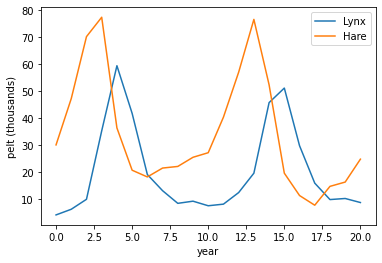

In [3]:
# data viz
pd.melt(lynx_hare_df, id_vars = 'Year').iloc[[0,20,21,41]]
pd.melt(lynx_hare_df, id_vars = 'Year').iloc[[0,1,20,21,40,41]].rename(columns = {'variable':'species', 'value':'pelts in thousands'})

ax = lynx_hare_df.loc[:, ['Lynx', 'Hare']].plot()
ax.set(xlabel='year', ylabel='pelt (thousands)') 

Text(0, 0.5, 'hare pelts (thousands)')

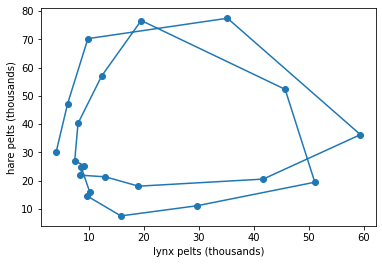

In [4]:
plt.scatter(lynx_hare_df.loc[:, 'Lynx'], lynx_hare_df.loc[:, 'Hare'])
plt.plot(lynx_hare_df.loc[:, 'Lynx'], lynx_hare_df.loc[:, 'Hare'])
plt.xlabel('lynx pelts (thousands)')
plt.ylabel('hare pelts (thousands)')


Plot of the number of lynx and hare pelts (in thousands) collected by the Hudson’s Bay Company between 1900 and 1920.

Plot of the number of pelts collected for lynx versus hares from 1900 to 1920. This plot is similar to that of the dynamics of a spring in phase space (i.e., position vs. momentum).

## Mechanistic Model: The Lotka-Volterra Equations

The Lotka-Volterra equations (Lotka 1925; Volterra 1926, 1927) are based on the assumptions that

- the predator population intrinsically shrinks,
- the prey population intrinsically grows,
- a larger prey population leads to a larger predator population, and
- a larger predator population leads to a smaller prey population.

More specifically, the rate of growth of the prey population is proportional to the size of the prey population, leading to exponential growth if unchecked. The prey population simultaneously shrinks at a rate proportional to the size of the product of the prey and predator populations. For the predator species, the direction of growth is reversed. The predator population shrinks at a rate proportional to its size and grows at a rate proportional to the product of its size and the prey population’s size.

Together, these dynamics lead to a cycle of rising and falling populations. With a low lynx population, the hare population grows. As the hare population grows, it allows the lynx population to grow. Eventually, the lynx population is large enough to start cutting down on the hare population. That in turn puts downward pressure on the lynx population. The cycle then resumes from where it started.

The Lotka-Volterra equations (Volterra 1926, 1927; Lotka 1925) are a pair of first-order, ordinary differential equations (ODEs) describing the population dynamics of a pair of species, one predator and one prey[<sup>5</sup>](#fn5).

* u(t)≥0 is the population size of the prey species at time t, and
* v(t)≥0 is the population size of the predator species.

Volterra modeled the temporal dynamics of the two species (i.e., population sizes over times) in terms of four parameters, $\alpha, \beta, \gamma, \delta \geq 0$, as

$$
\begin{eqnarray}
\frac{\mathrm{d}}{\mathrm{d}t} u
& = &  (\alpha - \beta v) u
& = & \alpha u - \beta u v
\\[6pt]
\frac{\mathrm{d}}{\mathrm{d}t} v
& = &  (-\gamma + \delta \, u) \, v
& = & -\gamma v + \delta uv
\end{eqnarray}
$$

As usual in writing differential equations, $u(t)$ and $v(t)$ are rendered as $u$ and $v$ to simplify notation.  The factor $\alpha$ is the growth rate of the prey population, whereas $\beta$ is the rate of shrinkage relative to the product of the population sizes.  The factor $\gamma$ is the shrinkage rate of the predator population and $\delta$ is the growth rate of the predator population as a factor of the product of the population sizes.


### Positivitity constraint and extinction

As measures of population sizes, the values of $u(t)$ and $v(t)$ must be non-negative(As in much of ecology, undead are frowned upon). Nothing in the differential equations here explicitly enforces positivity.  Nevertheless, as long as the initial populations are non-negative, i.e., $u(0) \geq 0$ and $v(0) \geq 0$, the values $u(t)$ and $v(t)$ for other times $t$ must also be non-negative.
This is because the rate of change in each population is a factor of the population size itself.

Although a population following the Lotka-Volterra dynamics will never become extinct,[<sup>7</sup>](#fn7) it may become arbitrarily small.   In reality, random events such as accidents can cause extinction events as can not so random events such as extensive hunting.  Therefore, the Lotka-Volterra model should not be expected to adequately model the dynamics of small populations.


### Behavior in the limit

One way to understand systems of equations is to consider their limiting behavior.  In this case, there are four behaviors, falling in two broad classes.

1. If both population sizes are initially positive, the populations will oscillate in a fixed pattern indefinitely, remaining positive.
2. If both population sizes are initially zero, the population sizes will remain zero.
3. If the predator population size is zero and the prey population size positive, the predator population size remains zero and the prey population grows without bound.
4. If the predator population size is positive and the prey population size zero, the prey population size remains zero while the predator population shrinks toward zero size (i.e., it asymptotes at zero).


<span id="fn7">7 The dodo (right), in 1682, before the population became extinct.</span>
![title](img/dodo.jpg"width="400")
<span style="font-size:70%; float:right"> 1682, Sir Thomas Herbert, public domain.</span>

<span id="fn5">5 Solutions to the Lotka-Volterra equations for predator and prey population sizes. The temporal trajectory of populations forms a stable orbit when plotted in two dimensions (Volterra 1926).</span>

![title](img/volterra-orbits.jpg)

<span style="font-size:70%; float:right">  © 1926, Nature Publishing Group</span>


## Statistical Model: Prior Knowledge and Unexplained Variation

### Solving the inverse problem

For a given legal value of the model parameters and initial state,  the Lotka-Volterra model predicts population dynamics into the future (and into the past).  But given noisy data about population dynamics, how do we solve the inverse problem, that of inferring the values of model parameters consistent with the data?  The general approach in Bayesian statistics is somewhat counterintuitive, as it involves formulating the forward model then using general principles to solve the inverse problem.

Specifically, a Bayesian model requires a mathematical model of what we know about the parameters (i.e., a prior) and a model of what we know about the data generating process given the parameters (i.e., a sampling distribution (The choice of prior is no more or less “subjective” than the choice of sampling distribution—both are mathematical approximations to some process of interest and as such must be validated for utility)).
Mathematically, a prior density $p(\theta)$ over the sequence of parameters $\theta$ encapsulates our knowledge of the parameters before seeing the data.  A sampling distribution (The sampling distribution p(θ|y) is called a likelihood function when considered as a function L(θ) of the parameters θ for fixed data y), which may have a continuous, discrete or mixed probability function, $p(y | \theta)$ characterizes the distribution of observable data $y$ given parameters $\theta$.

Bayes's rule gives us a general solution to the inverse problem, expressing the posterior $p(\theta | y)$ in terms of the prior $p(\theta)$ and likelihood $p(y | \theta)$[<sup>10</sup>](#fn10).

Stan provides a form of Markov chain Monte Carlo (MCMC) sampling that draws a sample $\theta^{(1)}, \ldots, \theta^{(M)}$ from the posterior to use for computational inference. Posterior quantities of interest may be expressed as derived random variables using functions $f(\theta)$ of parameters. Such functions may be used for posterior expectation calculations such as parameter estimates that minimize expected square error when $f(\theta) = \theta$, or event probabilities such as the probability of the hare population falling below some fraction of the lynx population, when $f(\theta)$ is some indicator function. 

### Measurement Error and Unexplained Variation

The Lotka-Volterra model is deterministic.  Given the system parameters and the initial conditions, the solutions to the equations are fully determined.  Population measurements are not so well behaved that they exactly follow the model; there is residual, unexplained variation, as well as measurement error.

There are factors that impact predator and prey population size other than the current population size.  There are variable environmental effects, such as weather, which will vary from season to season and year to year and affect population sizes.  Infectious diseases occasionally spread through a population, reducing its size (Hewitt 1921).  There are also more long-term environmental factors such as carrying capacity (Carrying capacity is roughly the maximum population that an environment can sustain. It is often modeled in the system dynamics as an asymptote on population size.).
In addition to factors that affect population which are not modeled, there is typically noise in the measurements. In this particular case, we cannot even measure the population directly.  Instead, pelts are used as a noisy proxy for population sizes (It would be possible to combine Lotka-Volterra dynamics with population models based on mark-recapture data, which are able to estimate actual population sizes, not just relative changes in proportions.). Hewitt (1921) further noted that animals are easier to trap when food is scarce, making the population measurements dependent on the population size.  Even the exact number of pelts taken is likely to be only approximate, as they were collected in a range of locations over an entire season.  Here, the number of pelts is rounded to the closest 100, building in measurement error on the order of 1% (Rounding can be modeled explicitly by allowing the true value to be a parameter; for instance if rounding is to the closest 100, the parameter can be modeled as uniform over the range ±50 from the measured value or even greater if the measurement on which the rounding was based may itself be in error.).

### A linear regression analogy

Like in a simple linear regression, we will proceed by treating the underlying determinstic model as providing an expected population value around which there will be variation due to both measurement error and simplifications in the scientific model.  Consider the typical formulation of a linear regression, where $y_n$ is an observable scalar outcome, $x_n$ is a row vector of unmodeled predictors (aka covariates, features), $\beta$ is a coefficient vector parameter, and $\sigma > 0$ is the error scale,

$$
\begin{eqnarray}
y_n & = & x_n \beta + \epsilon_n
\\[6pt]
\epsilon_n & \sim & \mathsf{Normal}(0, \sigma)
\end{eqnarray}
$$

The deterministic part of the equation is the linear predictor $x_n \beta$ with predictor $x_n$ (row $n$ of the data matrix $x$) and coefficient (column) vector $\beta$.  The stochastic error term, $\epsilon_n$, is assigned a normal distribution located at zero with scale parameter $\sigma > 0$ [<sup>16</sup>](#fn16). We typically formulate this model without the latent error variable $\epsilon_n$ as follows[<sup>17</sup>](#fn17), 

$$
y_n \sim \mathsf{Normal}(x_n \beta, \sigma).
$$


### Lotka-Volterra error model

Solutions to the Lotka-Volterra equations replace the linear predictor $x_n \, \beta$, but we maintain the error term to compensate for measurement error and unexplained variation in the data.  In the case of population dynamics, the data $y_n$ consists of measurements of the prey $y_{n, 1}$ and predator $y_{n, 2}$ populations at times $t_n$[<sup>18</sup>](#fn18).

The true population sizes at time $t = 0$ are unknown---we only have measurements $y^{\rm init}_1$ and $y^{\rm init}_2$ of them.  The true initial population sizes at time $t = 0$ will be represented by a parameter $z^{\mathrm init}$, so that

$$
\begin{array}{rcl}
z^{\mathrm init}_1 & = & u(t = 0)
\\[4pt]
z^{\mathrm init}_2 & = & v(t = 0).
\end{array}
$$

Next, let $z_1, \ldots, z_N$ be the solutions to the Lotka-Volterra differential equations at times $t_1, \ldots, t_N$ given initial conditions $z(t = 0) = z^{\mathrm init}$ and parameters $\theta = (\alpha, \beta, \gamma, \delta)$.  Each $z_n$ is a pair of prey and predator population sizes at the specified times,

$$
\begin{array}{rcl}
z_{n, 1} & = & u(t_n)
\\[4pt]
z_{n, 2} & = &  v(t_n).
\end{array}
$$

The $z_n$ are random variables, but they are deterministic functions of the random variables for the initial state $z^{\mathrm init}$ and system parameters $\alpha, \beta, \gamma, \delta$.

The observed data is in the form of measurements $y^{\rm init}$ of the initial population of prey and predators, and subsequent measurements $y_n$ of the populations at times $t_n$, where $y^{\mathrm init}$ and the $y_n$ consist of a pair of measured population sizes, for the prey and predator species.

In summary, the measurements, $y^{\rm init}$ and $y_n$, are drawn indepently from a normal distribution centered at the underlying population sizes, $z^{\rm init}$ and $z_n$, with noise scales $\sigma$.  Each quantity here, including the noise scale, is a pair consisting of values for prey and predator.



<span id="fn10">10 Bayes's rule for parameters $\theta$ and observed data $y$ is $$ \begin{array}{rcl} p(\theta\,|\, y) & = & \displaystyle \frac{p(\theta, y)}{p(y)} \\[4pt] & = & \displaystyle \frac{p(y | \theta) \, p(\theta)}{p(y)} \\[4pt] & = & \displaystyle \frac{p(y | \theta) \, p(\theta)}{\int_{\Theta} p(y | \theta) \, p(\theta) \, \mathrm{d}\theta} \\[4pt] & \propto & p(y | \theta) \, p(\theta). \end{array} $$</span>

<span id="fn11">11 The matrix of $\theta^{(m)}$ values (parameter by draw) is what is returned by the `extract()` function in Stan.</span>

<span id="fn12">12 The convergence result (as well as error bounds) follows from the MCMC central limit theorem when $\theta^{(m)}$ are drawn according to $p(\theta | y)$ with an appropriate MCMC algorithm,  $$ \begin{array}{rcl} \displaystyle \mathbb{E}[ \, f(\theta) \mid y \, ] & = & \int_{\Theta} \, f(\theta) \, p(\theta | y) \, \mathrm{d}\theta \\[4pt] & = & \lim_{M \rightarrow \infty} \, \frac{1}{M} \sum_{m=1}^M \, f\!\left(\theta^{(m)}\right) \\[4pt] & \approx & \frac{1}{M} \sum_{m=1}^M \, f\!\left(\theta^{(m)}\right) \ \ \mbox{ for some finite } M \end{array} $$</span>


<span id="fn16">16 Gauss initially noted that the maximum likelihood estimate derived from the normal error model is identical to the least square error estimate derived by minimizing the sum of squared errors, $ϵ^⊤ϵ$. With Markov, Gauss further proved that it was the lowest variance unbiased estimator.</span>

<span id="fn17">17 The latent error variable may be defined in terms of x, y, and $β$as
$ϵ_n=y_n−x_nβ$.</span>
    
<span id="fn18">18 This model makes the assumption that the underlying population sizes $z_{n,k}$ and measurements of it $y_{n,k}$ are continuous. This is a very tight approximation to counts when the numbers are in the thousands.</span>

### Multiplicative error and the lognormal distribution

It is common to log transform positive-only parameters so that they are no longer constrained to be positive.  On the log scale, we can then take the error to be unconstrained and additive, just as in linear regression.

$$
\begin{eqnarray}
\log y_{n, k} & = & \log z_{n, k} + \epsilon_{n, k}
\\[6pt]
\epsilon_{n, k} & \sim & \mathsf{Normal}(0, \sigma_k)
\end{eqnarray}
$$

where the $z_n$ are the solutions to the Lotka-Volterra equations at times $t_1, \ldots, t_N$ given initial populations $z^{\mathrm init}$.  The prey and predator populations have error scales (on the log scale) of $\sigma_1$ and $\sigma_2$.


With additive errors on the log transformed scales, the result of transforming back to the natural scale (by exponentiation) leads to multiplicative errors,

$$
\begin{array}{rcl}
y_{n, k} & = & \exp(\log z_{n, k} + \epsilon_{n, k})
\\[4pt]
         & = & z_{n, k} \, \exp(\epsilon_{n,k})
\end{array}
$$

Because $\exp(\epsilon_{n,k})$ is positive and the underlying population size $z_{n,k}$ is positive, their product will be positive. In other words, rather than the measurement being plus or minus some value, it's plus or minus some percentage of the total.

This transform and its associated fractional error is so common that they are jointly known as the lognormal distribution, so that we can simplify the above notation as we did with linear regression and write

$$
y_{n, k} \sim \mathsf{LogNormal}(z_{n, k}, \sigma_n).
$$
whenever
$$
\log y_{n, k} \sim \mathsf{Normal}(\log z_{n, k}, \sigma_n).
$$
The $\mathsf{LogNormal}$ density accounts for the non-linear change of variables through a Jacobian adjustment (The [Stan manual chapter on changes of variables](https://mc-stan.org/docs/2_23/stan-users-guide/changes-of-variables.html) works through the Jacobian adjustment for this particular change of variables.).

### Weakly informative priors

Our only remaining task is to formulate what we know about the parameters as priors.  In general, we recommend at least weakly informative priors on parameters (The Stan Development Team, in a [Wiki on prior choice recommendations](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations).). In practice, weakly informative priors inform the scale of the answer, but have only a negligible effect on the exact value;  that is, they are not very sensitive by design.  While not being very sensitive, they help enormously to ease computation, as Stan might otherwise work very hard to explore the outskirts of gnarly, unregularized distributions. In order to formulate such priors, we need to know the rough scale on which to expect an answer.  Because this model is well understood and widely used, as is the basic behavior of predator and prey species such as lynxes and hares, the parameter ranges leading to stable and realistic population oscillations are well known.



![title](img/n_logn.png"width="200")
The top figure shows the density of a standard normal variate, i.e., location (mean) 0 and scale (standard deviation) 1. The bottom figure the corresponding standard lognormal variate, i.e., log location 0 and log scale 1. The central 99.5% interval is shown in both cases with a dashed vertical line indicating the median and dotted lines the boundaries of the central 95% interval. The skew in the lognormal plot is due to the exponentiation—the range (2, 3) in the standard normal plot, containing only 2% of the total probability mass, maps to (7, 20) in the lognormal plot and still contains only 2% of the probability mass. If the horizontal and vertical axes were drawn to the same scale, the areas under the two curves would be identical.

### Priors for system parameters

For the parameters, recall that $\alpha$ and $\gamma$ are multipliers of $u$ and $-v$ respectively in the state equations, whereas $\beta$ and $\delta$ are multipliers of the product $u \, v$.  Combined with the fact that the scale of $u$ and $v$ are roughly 10 as the data has been encoded, we can formulate similar weakly informative priors,

$$
\begin{eqnarray}
\alpha, \gamma & \sim & \mathsf{Normal}(1, 0.5)
\\[6pt]
\beta, \delta & \sim & \mathsf{Normal}(0.05, 0.05)
\end{eqnarray}
$$

### Prior for noise scale

The noise scale is proportional, so the following prior should be weakly informative, as a value smaller than 0.05 or larger than 3 would be unexpected (The 95% interval is approximately the mean plus or minus two standard deviations, which here is exp(−1−2)≈0.05 and exp(−1+2)≈3). Because values are positive, this prior adopts the lognormal distribution (A lognormal prior on σσ is not consistent with zero values of σσ, but we do not expect the data to be consistent with values of σσ near zero because the model is not particularly accurate. It makes well calibrated predictions, but they are not very sharp.).

$$
\sigma \sim \mathsf{LogNormal}(-1, 1)
$$

Another reasonable prior choice would be a broad half normal.[<sup>23</sup>](#fn23)

<span id="fn23">23 An interval prior with hard boundaries is not recommended as it may bias results if the data is compatible with results near the boundary.</span>

![title](img/logn_1.png"width="200")

Plot of lognormal(-1, 1) prior. The median, 0.4, is highlighted with a dashed line and the central 95% interval, (0.05, 2.7), with dotted lines. This prior density is not consistent with values of sigma approaching zero.

![title](img/logn_2.png"width="200")

Plot of lognormal(log(10), 1) prior. The median, 2.3, is highlighted with a dashed line and the 95% interval, (1.4, 75), withdotted lines. This prior suffices for both predator and prey population sizes.


## Coding the Model: Stan Program

### Coding the system dynamics

Whenever a general system of differential equations is involved, the system equations must be coded as a Stan function.  In this case, the model is relatively simple as the state is only two dimensional and there are only four parameters.  Stan requires the system to be defined with exactly the signature defined here for the function <code>dz_dt()</code>, even if not all of them are used.  The first argument is for time, which is not used here because the rates in the Lotka-Voltarra equations do not depend on time. The second argument is for the system state, coded as an array
$z = (u, v)$.  The third argument is for the parameters of the equation, of which the Lotka-Voltarra equations have four, which are coded as $\theta = (\alpha, \beta, \gamma, \delta)$.  The fourth and fifth argument are for data constants, but none are needed here, so these arguments are unused.

```
real[] dz_dt(real t, real[] z, real[] theta,
             real[] x_r, int[] x_i) {
  real u = z[1];
  real v = z[2];
  real alpha = theta[1];
  real beta = theta[2];
  real gamma = theta[3];
  real delta = theta[4];
  real du_dt = (alpha - beta * v) * u;
  real dv_dt = (-gamma + delta * u) * v;
  return { du_dt, dv_dt };
}
```

After unpacking the variables from their containers, the derivatives of population with respect to time are defined just as in the mathematical specification.  The return value uses braces to construct the two-element array to return, which consists of the derivatives of the system components with respect to time,

$$
\frac{\mathrm{d}}{\mathrm{d}t} z
\ = \ \frac{\mathrm{d}}{\mathrm{d}t} (u, v)
\ = \ \left( \frac{\mathrm{d}}{\mathrm{d}t} u, \, \frac{\mathrm{d}}{\mathrm{d}t} v \right).
$$

The data variables are coded following their specifications,

```
data {
  int<lower = 0> N;           // num measurements
  real ts[N];                 // measurement times > 0
  real y_init[2];             // initial measured population
  real<lower = 0> y[N, 2];    // measured population at measurement times
}
```

as are the parameters,

```
parameters {
  real<lower = 0> theta[4];   // theta = { alpha, beta, gamma, delta }
  real<lower = 0> z_init[2];  // initial population
  real<lower = 0> sigma[2];   // error scale
}
```

The solutions to the Lotka-Volterra equations for a given initial state $z^{\mathrm init}$ are defined as transformed parameters.  This will allow them to be used in the model and inspected in the output (as we do in later graphs).  It also makes it clear that they are all functions of the initial population and parameters (as well as the solution times (Stan provides two solvers, a Runge-Kutta 4th/5th-order solver (_rk45) and a backwards-differentiation formula solver (_bdf) for stiff systems. The RK45 solver is twice as fast as the BDF solver for this data. The symptom of stiffness is slow iterations that may appear to be hanging if a large number of iterations is permitted. If the solver runs into stiffness and more careful initialization or prior choice does not mitigate the problem, the BDF solver may be used to adjust for the ill-conditioned Jacobians at the cost of increased computation time.)).
```
transformed parameters {
  real z[N, 2]
    = integrate_ode_rk45(dz_dt, z_init, 0, ts, theta,
                         rep_array(0.0, 0), rep_array(0, 0),
                         1e-6, 1e-5, 1e3);
}
```

The required real and integer data arguments in the second line are both given as constant size-zero arrays.  The last line provides relative and absolute tolerances, along with the maximum number of steps allowed in the solver before rejecting (Rejections behave like zero density points from which no progress may be made; in C++, the behavior is to throw an exception, which is caught and displayed as an error message by the interfaces.). For further efficiency, the tolerances for the differential equation solver are relatively loose for this example; usually tighter tolerances are required (smaller numbers).

With the solutions in hand, the only thing left are the prior and likelihood.  As with the other parts of the model, these directly follow the notation in the mathematical specification.

```
model {
  theta[{1, 3}] ~ normal(1, 0.5);
  theta[{2, 4}] ~ normal(0.05, 0.05);
  sigma ~ lognormal(-1, 1);
  z_init ~ lognormal(log(10), 1);
  for (k in 1:2) {
    y_init[k] ~ lognormal(log(z_init[k]), sigma[k]);
    y[ , k] ~ lognormal(log(z[, k]), sigma[k]);
  }
}
```

The multiple indexing `theta[{1, 3}]` indicates that both `theta[1]` and `theta[3]` get the prior `normal(1, 0.5)`;  it is both more efficient and more compact to represent them this way.  The second sampling statement involving `y[ , k]` is vectorized and amounts to the same thing as an additional loop,

```
for (n in 1:N)
  y[n, k] ~ lognormal(log(z[n, k]), sigma[k])
```

As with the prior, the vectorized form used in the actual model block is much more efficient.  The `y_init` sampling statement could be pulled out of the loop, but there is not much efficiency gain as there are only two elements, so it is left in this form for clarity.





## Solving the Inverse Problem: Bayesian Inference in Stan

### Fitting the Hudson's Bay Company data

First, the data is munged into a form suitable for Stan and printed. 


In [5]:
N = lynx_hare_df.shape[0] - 1
ts = np.arange(1, N + 1)
y_init = lynx_hare_df.loc[0, ['Hare', 'Lynx']]
y = lynx_hare_df.loc[1:, ['Hare', 'Lynx']]

data = {
    "N": N,
    "ts": ts,
    "y_init": list(y_init),
    "y": y.values.tolist(),
}
print("N:",N,"\nts:",ts,"\ny_init:",list(y_init),"\ny:\n",y)

N: 20 
ts: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
y_init: [30.0, 4.0] 
y:
     Hare  Lynx
1   47.2   6.1
2   70.2   9.8
3   77.4  35.2
4   36.3  59.4
5   20.6  41.7
6   18.1  19.0
7   21.4  13.0
8   22.0   8.3
9   25.4   9.1
10  27.1   7.4
11  40.3   8.0
12  57.0  12.3
13  76.6  19.5
14  52.3  45.7
15  19.5  51.1
16  11.2  29.7
17   7.6  15.8
18  14.6   9.7
19  16.2  10.1
20  24.7   8.6


Next, we call the filepath of stanfile `lotka-volterra.stan`  containing the model code. The CmdStanModel class specifies the Stan program and its corresponding compiled executable.

Finally, the compiled model and data are used for sampling. Stan's default settings are sufficient for this data set and model.


In [6]:
path = os.path.join('.','lotka-volterra.stan')
model = CmdStanModel(stan_file=path)
fit = model.sample(data=data)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/hyunjimoon/Dropbox/stan/casestudy/lotka-volterra/lotka-volterra
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3


The output can be displayed in tabular form.


In [7]:
fit.summary().round(decimals=3).iloc[1:10,:]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
theta[1],0.545,0.002,0.063,0.444,0.543,0.653,922.441,32.530,1.005
theta[2],0.028,0.000,0.004,0.021,0.027,0.035,975.638,34.406,1.004
theta[3],0.803,0.003,0.091,0.666,0.796,0.963,871.419,30.731,1.005
theta[4],0.024,0.000,0.004,0.019,0.024,0.031,935.249,32.982,1.005
z_init[1],34.003,0.054,2.957,29.253,33.902,39.066,2998.590,105.746,1.001
z_init[2],5.939,0.011,0.524,5.126,5.915,6.820,2209.530,77.920,1.000
sigma[1],0.249,0.001,0.044,0.189,0.245,0.327,2499.520,88.146,1.000
sigma[2],0.252,0.001,0.043,0.191,0.246,0.332,2604.320,91.842,1.001
"z[1,1]",49.259,0.100,4.600,42.068,48.967,57.186,2129.400,75.094,1.002


There were no divergent transitions[<sup>27</sup>](#fn27) reported.  The $\hat{R}$ values are all near 1, which is consistent with convergence.  The effective sample size estimates for each parameter are sufficient for inference.[<sup>28</sup>](#fn28) Thus we have reason to trust that Stan has produced an adequate approximation of the posterior.


<span id="fn27">27 Divergences occur when Stan’s Hamiltonian solver diverges from the true Hamiltonian, which must be conserved, because of numerical problems in the stepwise gradient-based approximation of the curvature of the log density.</span>

<span id="fn28">28 With effective sample sizes of roughly one thousand, standard errors are roughly one thirtieth the size of posterior standard deviations, being in an inverse square root relation.</span>


## Comparing the fitted model to data

Using a non-statistically motivated error term and optimization, Howard (2009, Figure 2.10) provides the following point estimates for the model parameters based on the data.
$$
\alpha^* = 0.55, \ \
\beta^* = 0.028, \ \
\gamma^* = 0.84, \ \
\delta^* = 0.026
$$

Our model produced the following point estimates based on the posterior mean,[<sup>29</sup>](#fn29)

$$
\hat{\alpha} = 0.55, \ \
\hat{\beta} = 0.028, \ \
\hat{\gamma} = 0.80, \ \
\hat{\delta} = 0.024,
$$

which are very close to Howard's estimates. [<sup>30</sup>](#fn30) The posterior intervals, which are quite wide here, may be interpreted probabilistically,

$$
\begin{array}{ccc}
\mbox{Pr}[0.47 \leq \alpha \leq 0.63] & = & 0.8
\\[4pt]
\mbox{Pr}[0.23 \leq \beta \leq 0.33] & = & 0.8
\\[4pt]
\mbox{Pr}[0.69 \leq \delta \leq 0.91] & = & 0.8
\\[4pt]
\mbox{Pr}[0.020 \leq \gamma \leq 0.029] & = & 0.8
\end{array}
$$
The effect of these estimates is plotted later with simulated population orbits.

Error scales for both populations have the same posterior mean estimate,

$$
\hat{\sigma}_1 \ = \ \hat{\sigma}_2 \ = \ 0.25.
$$

and both have the same posterior 80% interval, (0.20, 0.31).[<sup>31</sup>](#fn31) 

## Inference for population sizes

One inference we would like to make from our data is the size of the lynx and hare populations over time. Technically, we can only estimate the expected sizes of future pelt collections and must assume the population is somehow directly related to the numbers of pelts collected.  Howard (2009) plugs in optimization-derived point estimates to derive population predictions.

Rather than plugging in point estimates to get point predictions, we will follow the fully Bayesian approach of adjusting for uncertainty.  This uncertainty takes two forms in inference.  First, there is estimation uncertainty, which is fully characterized by the joint posterior density $p(\alpha, \beta, \gamma, \delta, z^{\mathrm init}, \sigma \mid y)$.[<sup>32</sup>](#fn32)

The second form of uncertainty stems from measurement error and unexplained variation, which are both rolled into a single sampling distribution, $\log y_n \sim \mathsf{Normal}(\log z_n, \sigma)$.  As in the Stan implementation, $z_n = (u_n, v_n)$ is the solution to the differential equation conditioned on the parameters $\theta = (\alpha, \beta, \gamma, \delta, \sigma)$ and initial state $z^{\mathrm init}$.

## Posterior predictive checks


We use posterior predictive checks to evaluate how well our model fits the data from which it was estimated.[<sup>33</sup>](#fn33)


The basic idea is to take the posterior for the fitted model and use it to predict what the data should've looked like.  That is, we will be replicating new $y$ values that parallel the actual observations $y$.  Becuase they are replicated values, we write them as as $y^{\mathrm{rep}}$.  The distribution of these replicated values is given by the posterior predictive distribution,


$$
p(y^{\mathrm{rep}} | y)
\ = \
\int p(y^{\mathrm{rep}} | \theta) \ p(\theta | y) \ \mathrm{d}\theta,
$$

where $\theta = (\alpha, \beta, \gamma, \delta, z^{\mathrm init}, \sigma)$ is the vector of parameters for the model.  Our two forms of uncertainty are represented in the two terms in the integral.  The first is the sampling distribution for the replications, $p(y^{\mathrm rep} | \theta)$, which is the distribution of observations $y^{\mathrm rep}$ given parameters $\theta$.  This term encapsulates the unexplained variance and measurement error. The second term is the posterior $p(\theta | y)$, which encapsulates our uncertainty in our parameter estimates $\theta$ given the observations $y$.  Here, the integral takes a weighted average of the sampling distribution, with weights given by the posterior.  In statistical terms, we are calculating an expectation of a function of the parameters, $f(\theta) = p(y^{\mathrm rep} | \theta)$, over  the posterior $p(\theta | y)$, which can be written concisely as a conditional expectation,

$$
p(y^{\mathrm{rep}} | y)
\ = \
\mathbb{E}\!\left[ \, p(y^{\mathrm{rep}} | \theta) \ \, \big| \ \, y \, \right].
$$


## Stan code for posterior predictive checks

Stan defines predictive quantities in the generated quantities block, which is executed once per iteration.[<sup>34</sup>](#fn34) The code declares variables at the top of the block, then defines them in a loop over the species, then over the times.

```
generated quantities {
  real y_init_rep[2];
  real y_rep[N, 2];
  for (k in 1:2) {
    y_init_rep[k] = lognormal_rng(log(z_init[k]), sigma[k]);
    for (n in 1:N)
      y_rep[n, k] = lognormal_rng(log(z[n, k]), sigma[k]);
  }
}
```


In [8]:
drawset_pd = fit.get_drawset()

In [9]:
y_init_rep_draws = drawset_pd.filter(like='y_init_rep', axis=1)
y_rep_draws = drawset_pd.filter(like='y_rep', axis=1).to_numpy().reshape((4000,20,2), order='A')
y_rep_draws.shape

(4000, 20, 2)

In [10]:
predicted_pelts = pd.DataFrame(index = lynx_hare_df['Year'], columns = {'Hare','Lynx'})
predicted_pelts.iloc[0] = y_init_rep_draws.mean().values
for i in range(2):
    predicted_pelts.iloc[1:,i] = np.mean(y_rep_draws[:,:,i], axis=0)
    predicted_pelts.iloc[1:,i] = np.mean(y_rep_draws[:,:,i], axis=0)

In [11]:
min_pelts = pd.DataFrame(index = lynx_hare_df['Year'], columns = {'Hare', 'Lynx'})
min_pelts.iloc[0] = np.quantile(y_init_rep_draws, 0.25)
for i in range(2):
    min_pelts.iloc[1:,i] = np.quantile(y_rep_draws[:,:,i], 0.25, axis=0)
    min_pelts.iloc[1:,i] = np.quantile(y_rep_draws[:,:,i], 0.25, axis=0)

max_pelts = pd.DataFrame(index = lynx_hare_df['Year'], columns = {'Hare', 'Lynx'})
max_pelts.iloc[0] = np.quantile(y_init_rep_draws, 0.75)
for i in range(2):
    max_pelts.iloc[1:,i] = np.quantile(y_rep_draws[:,:,i], 0.75, axis=0)
    max_pelts.iloc[1:,i] = np.quantile(y_rep_draws[:,:,i], 0.75, axis=0)

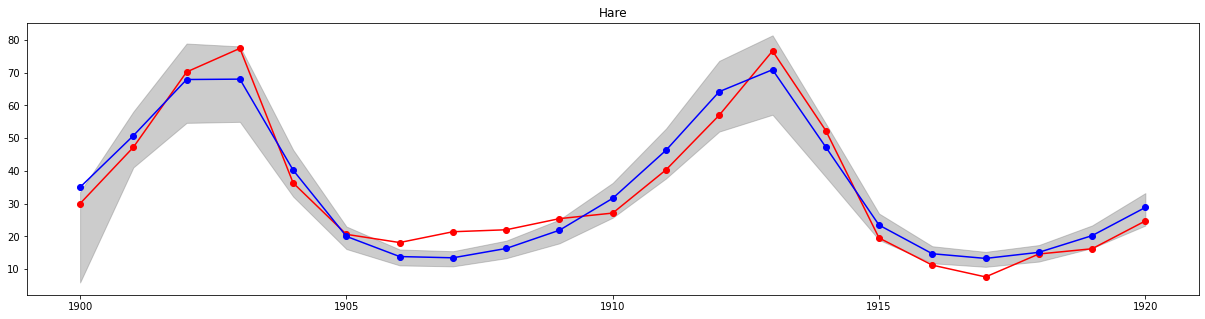

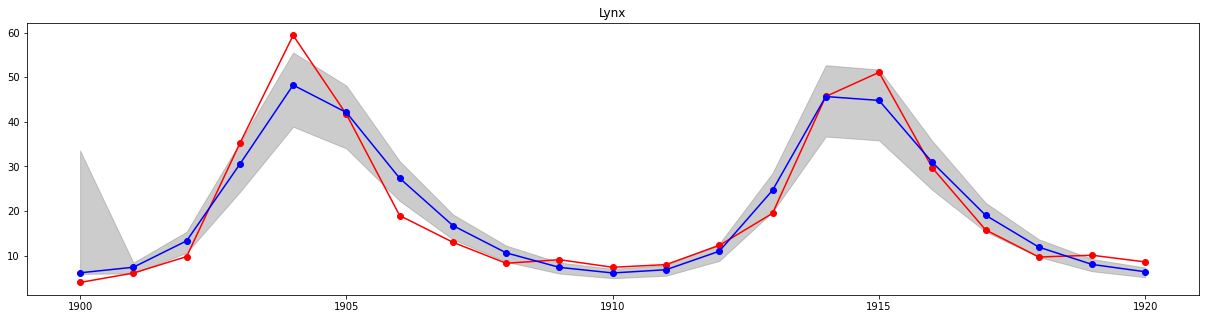

In [12]:
plt.figure(figsize=(21, 5))
plt.plot(range(1900,1921),lynx_hare_df['Hare'],color='red',marker='o')
plt.plot(range(1900,1921),predicted_pelts['Hare'],color='blue',marker='o')
plt.fill_between(range(1900,1921), list(min_pelts['Hare']),list(max_pelts['Hare']),color='grey',alpha=0.4)
plt.title("Hare")
plt.xticks(range(1900,1921,5))


plt.figure(figsize=(21, 5))
plt.plot(range(1900,1921),lynx_hare_df['Lynx'],color='red',marker='o')
plt.plot(range(1900,1921),predicted_pelts['Lynx'],color='blue',marker='o')
plt.fill_between(range(1900,1921), list(min_pelts['Lynx']),list(max_pelts['Lynx']),color='grey',alpha=0.4)
plt.title('Lynx')
plt.xticks(range(1900,1921,5))

plt.show()

Posterior predictive checks, including posterior means and 50% intervals along with the measured data. If the model is well calibrated, as this one appears to be, 50% of the points are expected to fall in their 50% intervals.


The uncertainty due to parameter estimation is rolled into the values of `z_init`, `z`, and `sigma`.  The uncertainty due to unexplained variation and measurement error is captured through the use of the lognormal pseudorandom number generator, `lognormal_rng`.  The additional noise in the measurements `y` over that of the underlying population predictions `z` is visualized in the plots.

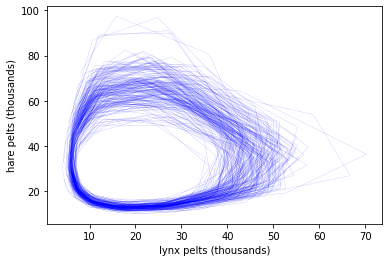

In [13]:
z_draws = drawset_pd.filter(like='z.', axis=1).to_numpy().reshape((4000,20,2), order='A')
z_hare=z_draws[1:101,:,0].T
z_lynx=z_draws[1:101,:,1].T
plt.plot(z_lynx,z_hare,color='blue',alpha=0.8,linewidth=0.1)
plt.xlabel("lynx pelts (thousands)")
plt.ylabel("hare pelts (thousands)")
plt.show()

Plot of expected population orbit for one hundred draws from the posterior. Each draw represents a different orbit determined by the differential equation system parameters. Together they provide a sketch of posterior uncertainty for the expected population dynamics. If the ODE solutions were extracted per month rather than per year, the resulting plots would appear fairly smooth.

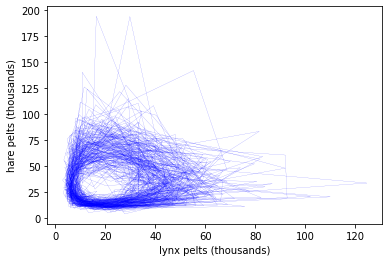

In [14]:
y_hare=y_rep_draws[1:101,:,0].T
y_lynx=y_rep_draws[1:101,:,1].T
plt.plot(y_lynx,y_hare,color='blue',linewidth=0.1)
plt.xlabel("lynx pelts (thousands)")
plt.ylabel("hare pelts (thousands)")
plt.show()

Plot of expected pelt collection orbits for one hundred draws of system parameters from the posterior. Even if plotted at more fine-grained time intervals, error would remove any apparent smoothness. Extreme draws as seen here are typical when large values have high error on the multiplicative scale.

<span id="fn29">29  The posterior mean minimizes expected squared error, whereas posterior medians minimize expected absolute error. Here, the mean and median are the same to within MCMC standard error.</span>

<span id="fn30">30 Discrepancies are to be expected in that we are finding a posterior mean wheras Howard is finding a posterior mode. We do not suspect the priors have a strong influence here, but this could be checked by varying them and comparing results, i.e., performing a sensitivity analysis.</span>


<span id="fn31">31 This suggests they may be completely pooled and modeled using a single parameter.</span>

<span id="fn32">32 In well-behaved models in which the data is broadly consistent with the prior and likelihood, estimation uncertainty is reduced by larger samples; as more data is available, it will overwhelm the fixed priors and the posterior will concentrate around the true values of the parameters.</span>


<span id="fn33">33 This is “testing on the training data” in machine learning parlance, and while we would not trust it for final evaluation, it is an easy way to spot inconsistencies in the implementation of misspecification in the model.</span>

<span id="fn34">34 The log density and its gradient are typically evaluated many times per iteration to follow the Hamiltonian trajectory of the parameters given some initial momenta.</span>

# Conclusion: What are the Population Dynamics?

Even with the strong assumption that the number of pelts collected is proportional to the population, we only know how the relative sizes of the populations change, not their actual sizes.


## Predicted population cycles


In the same way as Volterra (1926) plotted the cycles of predator and prey populations, we can select draws of $z^{\mathrm rep}$ from the posterior and plot them. The variation here is due to posterior uncertainty in the value of the system parameters $\alpha, \beta, \gamma, \delta$ and the initial population $z^{\mathrm init}$.

## Predicted measurements

In addition to the estimation uncertainty discussed in the previous section, there is also the general error due to measurement error, model misspecification, etc.  In order to simulate the number of pelts that are reported collected (which may itself have error relative to the actual number of pelts), we must additionally consider the general error term.  That is already rolled into the variables $y^{\mathrm rep}$, so we plot those here.


# Exercises and Extensions 

The Lotka-Volterra model is easily extended for realistic applications in several obvious ways.  I ran out of steam before turning this case study into a book on Bayesian modeling.  I leave the next steps for this model to the dedicated reader. [<sup>35</sup>](#fn35) Even if you don't plan to do the exercises, they provide a concise description of where this model can be taken.

1.  *Simulation-based calibration*.  Write a Stan model to simulate data from this model.  First simulate parameters from the prior (or pick ones consistent with the priors).  Then simulate data from the parameters.  Finally, fit the model in Stan and compare the coverage as in the last plot in the case study.[<sup>36</sup>](#fn36)

1.  *Forecasting and backcasting*.  Extend predictions another 50 years into the future and plot as in the last plot.  This can be done by extending the solution points in the transformed parameters, but is more efficiently done in the generated quantities block.  Next, extend the predictions 50 years into the past and plot.[<sup>37</sup>](#fn37) Is there anything suspicious about the long-term uncertainty measures?

1.  *Missing data*.  Suppose that several of the measurements are missing.  Write a Stan program that uses only the observed measurements.  This will require coding the data in long form [<sup>38</sup>](#fn38) as
```
int J;                  // num observations
int spec[J];            // species for obs j
real tt[J];             // time for obs j
real<lower = 0> yy[J];  // yy[j] == y[tt[j], spec[j]]
```
and coding the model as
```
for (j in 1:J)
  yy[j] ~ normal(zz[tt[j], spec[j]], sigma[spec[j]]);
```
Only this part of the model changes;  the ODE is set up and fit as before with the complete set of time points.  What happens to the computation and posterior inferences as increasing amounts of data are missing?  How can the missing data points be imputed using the generated quantities block?[<sup>39</sup>](#fn39)
1.  *Error model.* Replace the lognormal error with a simple normal error model.  What does this do to the `z` estimates and to the basic parameter estimates?  Which error model fits better?
1.  *Sensitivity analysis and prior choice*.  Perform a sensitivity analysis on the prior choices made for this model.  When the prior means or scales are varied, how much does the posterior vary?  Does the model become easier or harder to fit (in terms of effective sample size per unit time or divergent transitions) with different prior choices?  What does this imply about the number of digits with which we report results and thus the effective sample sizes necessary for most inferences?
1. *Model misspecification.* Swap the coding of the lynx and hare in the input so that the predator is modeled as prey and vice-versa.   How well does it fit the data?  How does this provide evidence for the folk theorem?[<sup>40</sup>](#fn40)

1. *Multiple species.* Extend the model to deal with more than one species.  Treat each species as as having a mixture of predators and a mixture of prey affecting its growth.  Simulate data and fit to your model.  Do the equations become stiff as more species and interactions are added?  How much data is required to identify the model as the number of species and their mixing increases?[<sup>41</sup>](#fn41)
1. *Covariates.*  Suppose we have measured covariates such as temperature, water, and plant abundance.  Set up a model where these have further effects on populations modeled as unconstrained multiplies of the existing species size.  Simulate data using your covariates.  What does the existence of covariates do to the uncertainty estimates compared to using a model without covariates?
1. *Joint mark-recapture modeling*.  Suppose that we also have mark-recapture data for each species over the same time period.  Find or simulate such data.   Build a mark-recapture model such as Cormack-Jolly-Seber and jointly model the population in terms of the CJS model and the Lotka-Volterra model.[<sup>42</sup>](#fn42) How can you scale the population dynamics model in order to work at the same scale as the mark-recapture model?  Does this reduce uncertainty in the population dynamics?  Does the joint model improve on fitting the mark-recapture model or Lotka-Volterra models separately?
1. *Measurement error*.  Suppose the number of lynx pelts collected is affected by the size of the population.  In particular, suppose a larger proportion of lynx are captured when they are hungry. How cold this be included as a component of the model?  What parameter would be introduced?  Simulate data and see if the true populations can be recovered with the model.
1. *Carrying capacity*.  How can a carrying capacity (upper bound on population size) be incorporated into the Lotka-Volterra model?  Formulate the model in Stan and fit it to simulated data.  If the data is simulated near the carrying capacity, how does it fit using the simpler Lotka-Volterra model?
1. *Cross-validation and predictive calibration*.  Cross validation as such doesn't make much sense for time series.  Nevertheless, it is possible to fit data to initial sequences of a time series and predict the remaining sequence.  How could this be achieved here?[<sup>43</sup>](#fn43) Do you need to write more than one Stan model?

<span id="fn35">35 If you complete a few of these exercises and write them up, please [let me know](mailto:carp@alias-i.com) I'd be happy to extend this case study and add a co-author or publish a follow-on case study.</span>

<span id="fn36">36 This basic validation technique was extended and converted to a statistical test of MCMC algorithm fit by Cook, Gelman and Rubin (2006). Their test of Bayesian calibration relies on data simulated from the model being calibrated by construction in full Bayesian posterior inference. As extra credit, apply this test to validate the model.</span>

<span id="fn37">37 *Hint*: the initial time will have to be changed in the call to ode_integrate.</span>

<span id="fn38">38 Long form is known as “melted” in R’s Tidyverse.</span>

<span id="fn39">39 There is a chapter on missing data with more details in the Stan manual.</span>

<span id="fn40">40 *Folk Theorem* (Gelman) When you have computational problems, often there’s a problem with your model.</span>

<span id="fn41">41 *Hint*: see Michael Betancourt’s case study on mixture models on the Stan web site for general advice on mixture modeling.</span>

<span id="fn42">42 The Stan manual chapter on latent discrete parameters describes how to code the Cormack-Jolly-Seber model for mark-recapture data.</span>

<span id="fn43">43 *Hint*: Considier using the [`loo`](http://mc-stan.org/loo/) package for leave-one-out cross-validation (Vehtari, Gelman, and Gabray 2017).</span>

## References

* Cook, S. R., Gelman, A., & Rubin, D. B. (2006)  Validation of software for Bayesian models using posterior quantiles. *Journal of Computational and Graphical Statistics*, 15(3), 675--692.
* Hewitt, C. G. (1921) [*The Conservation of the Wild Life of Canada*](https://books.google.com/books?id=8hVDAAAAIAAJ). Charles Scribner's Sons.
* Howard, P. (2009). [Modeling basics](http://www.math.tamu.edu/~phoward/m442/modbasics.pdf). Lecture Notes for Math 442, Texas A&M University.
* Lotka, A. J. (1925). *Principles of physical biology*. Baltimore: Waverly.
* Rogers, K. (2011) [The rise and fall of the Canada lynx and snowshoe hare]( http://blogs.britannica.com/2011/06/rise-fall-canada-lynx-snowshoe-hare/). *Encyclopedia Brittanica Blog*.
* Stan Development Team (2017) *Stan Modeling Language Users Guide and Reference Manual*, Version 2.17, [http://mc-stan.org](http://mc-stan.org).
* Vehtari, A., Gelman, A. & Gabry, J. (2017) Practical Bayesian model evaluation using leave-one-out cross-validation and WAIC.   *Journal of Statistics and Computing* 27(5):1413--1432.
* Volterra, V. (1926). Fluctuations in the abundance of a species considered mathematically. *Nature*, 118(2972), 558-560.
* Volterra, V. (1927). *Variazioni e fluttuazioni del numero d'individui in specie animali conviventi*. C. Ferrari.

## Source code

All of the source code, data, text, and images for this case study are available on GitHub at

* [stan-dev/example-models/knitr/lotka-volterra](https://github.com/stan-dev/example-models/tree/master/knitr/lotka-volterra)


## Acknowledgements 

Thanks to Simon Woodward, Arya Pourzanjani, and Leo Lahti for helpful comments on earlier drafts and Peter Howard for providing the provenance of the data and the original case study with the data.  Thanks to Joss Wright for patching an illegally formed data object.

<br />


## Complete Stan program 


Here is the complete Stan program for solving the inverse problem for the Lotka-Volterra model, including posterior predictive checks.

```
functions {
  real[] dz_dt(real t,       // time
               real[] z,     // system state {prey, predator}
               real[] theta, // parameters
               real[] x_r,   // unused data
               int[] x_i) {
    real u = z[1];
    real v = z[2];
    real alpha = theta[1];
    real beta = theta[2];
    real gamma = theta[3];
    real delta = theta[4];
    real du_dt = (alpha - beta * v) * u;
    real dv_dt = (-gamma + delta * u) * v;
    return { du_dt, dv_dt };
  }
}
data {
  int<lower = 0> N;          // number of measurement times
  real ts[N];                // measurement times > 0
  real y_init[2];            // initial measured populations
  real<lower = 0> y[N, 2];   // measured populations
}
parameters {
  real<lower = 0> theta[4];   // { alpha, beta, gamma, delta }
  real<lower = 0> z_init[2];  // initial population
  real<lower = 0> sigma[2];   // measurement errors
}
transformed parameters {
  real z[N, 2]
    = integrate_ode_rk45(dz_dt, z_init, 0, ts, theta,
                         rep_array(0.0, 0), rep_array(0, 0),
                         1e-5, 1e-3, 5e2);
}
model {
  theta[{1, 3}] ~ normal(1, 0.5);
  theta[{2, 4}] ~ normal(0.05, 0.05);
  sigma ~ lognormal(-1, 1);
  z_init ~ lognormal(log(10), 1);
  for (k in 1:2) {
    y_init[k] ~ lognormal(log(z_init[k]), sigma[k]);
    y[ , k] ~ lognormal(log(z[, k]), sigma[k]);
  }
}
generated quantities {
  real y_init_rep[2];
  real y_rep[N, 2];
  for (k in 1:2) {
    y_init_rep[k] = lognormal_rng(log(z_init[k]), sigma[k]);
    for (n in 1:N)
      y_rep[n, k] = lognormal_rng(log(z[n, k]), sigma[k]);
  }
}
```





## Licenses  

<span style="font-size:85%">Code &copy; 2017--2018, Trustees of Columbia University in New York, licensed under BSD-3.</span>

<span style="font-size:85%">Text &copy; 2017--2018, Bob Carpenter, licensed under CC-BY-NC 4.0.</span>